In [1]:
"""
@author: albertigno

"""

from DatasetLoader import *
import torch, time, os
import torch.nn as nn
import torch.nn.functional as F
#import networkx as nx
import matplotlib.pyplot as plt
#from matplotlib.gridspec import GridSpec

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
print ('Running on: {}'.format(device))

dataset = 'shd'
ds_method = dataset
dataset_path = r'./../../datasets'
thresh = 0.3

if dataset == 'shd':
    batch_size = 256 # default 256
    learning_rate = 1e-4 # default 1e-4
    time_window = 50 # shd 50, nmnist 25-30
    #time_window = 100
    train_path = dataset_path+'/shd_digits/shd_train.h5'
    test_path = dataset_path+'/shd_digits/shd_test.h5'
elif dataset == 'marshalling':
    batch_size = 20 # default 256
    learning_rate = 1e-4 # default 1e-4
    time_window = 50 # shd 50, nmnist 25-30
    #time_window = 100
    ds_method = 'nmnist'
    train_path = dataset_path+'/marshalling/marshalling50_d5_train.mat'
    test_path = dataset_path+'/marshalling/marshalling50_d5_test.mat'    
elif dataset == 'nmnist':
    batch_size = 200 
    learning_rate = 1e-4
    time_window = 25     
    train_path = dataset_path+'/nmnist/nmnist_train.mat'
    test_path = dataset_path+'/nmnist/nmnist_test.mat'  
    
# load datasets
print("loading test set...")
test_dataset = DatasetLoader(test_path, ds_method, time_window, 'cpu')
print("loading training set...")
train_dataset = DatasetLoader(train_path, ds_method, time_window, device)
print("loading data with pytorch")
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False, drop_last=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True, drop_last=True)
    

Running on: cuda:0
loading test set...
num sample: 2264
torch.Size([2264, 50, 700]) torch.Size([2264, 20])
loading training set...
num sample: 8156
torch.Size([8156, 50, 700]) torch.Size([8156, 20])
loading data with pytorch


In [2]:
from snn_models import *
%load_ext autoreload
%autoreload 1
%aimport snn_models

num_hidden = 512
#tau_m = 'adp'
tau_m = 0.8305
#snn = RSNN_delay(d='shd', num_hidden=128, thresh=0.3, decay=0.3, batch_size=batch_size, win=50, device=device)
#snn = RSNN('custom_3588_10', num_hidden=num_hidden, thresh=0.3, tau_m=tau_m, vreset=0.0, batch_size=batch_size, win=time_window, device=device)
snn = RSNN(dataset, num_hidden=num_hidden, thresh=0.3, tau_m=tau_m, vreset=0.0, batch_size=batch_size, win=time_window, device=device)
snn.to(device)

RSNN(
  (fc_ih): Linear(in_features=700, out_features=512, bias=False)
  (fc_hh): Linear(in_features=512, out_features=512, bias=False)
  (fc_ho): Linear(in_features=512, out_features=20, bias=False)
)

In [3]:
# training configuration

num_epochs = 20
modelname = '{}_rnn_{}_{}.t7'.format(dataset, snn.num_hidden, tau_m)
num_samples = train_dataset.images.size()[0]

# super pythonic way to extract the parameters that will have 'normal' learning rate
base_params = [getattr(snn,name.split('.')[0]).weight for name, _ in snn.state_dict().items() if name[0]=='f']

# setting different learning rate for tau_m, if neeeded
if tau_m=='adp':
    optimizer = torch.optim.Adam([
        {'params': base_params},
        {'params': snn.tau_m_h, 'lr': learning_rate * 10.0},
        {'params': snn.tau_m_o, 'lr': learning_rate * 10.0}],
        lr=learning_rate)
else:    
    optimizer = torch.optim.Adam([
        {'params': base_params}],
        lr=learning_rate)
    
act_fun = ActFun.apply
print(modelname)

shd_rnn_512_0.8305.t7


In [4]:
# training loop
taus_m = []
for epoch in range(num_epochs):
    print('Epoch [%d/%d]'  % (epoch + 1, num_epochs))
    start_time = time.time()
    snn.train_step(train_loader, optimizer=optimizer, criterion=nn.MSELoss(), num_samples = num_samples, spkreg=0.1)
    t =  time.time() - start_time
    print('Time elasped:', t)
    
    # adjust learning rate
    optimizer = snn.lr_scheduler(optimizer, lr_decay_epoch=1)
    
    # weight and decay recording
    #taus_m.append((snn.tau_m_h.data.detach().clone(), snn.tau_m_o.data.detach().clone()))
    
    if (epoch + 1) % 5 == 0:
        snn.test(test_loader, criterion=nn.MSELoss())
        #snn.save_model(modelname)     
                
with open('training_log', 'a') as logs:
    logs.write("\nFinished training {} epochs for {}, batch_size {}, time_per_epoch {} s".format(num_epochs, modelname, batch_size, t))       

Epoch [1/20]
Step [10/31], Loss: 0.59379
Step [20/31], Loss: 0.53715
Step [30/31], Loss: 0.51322
Time elasped: 2.9421536922454834
Epoch [2/20]
Step [10/31], Loss: 0.49453
Step [20/31], Loss: 0.48410
Step [30/31], Loss: 0.47655
Time elasped: 2.386866331100464
Epoch [3/20]
Step [10/31], Loss: 0.46827
Step [20/31], Loss: 0.46021
Step [30/31], Loss: 0.45719
Time elasped: 2.402754545211792
Epoch [4/20]
Step [10/31], Loss: 0.45176
Step [20/31], Loss: 0.44640
Step [30/31], Loss: 0.44445
Time elasped: 2.427008628845215
Epoch [5/20]
Step [10/31], Loss: 0.43919
Step [20/31], Loss: 0.43575
Step [30/31], Loss: 0.43327
Time elasped: 2.4214813709259033
avg spk_count per neuron for all 50 timesteps 1.1204833984375
Test Accuracy of the model on the test samples: 34.521
Epoch [6/20]
Step [10/31], Loss: 0.42878
Step [20/31], Loss: 0.42726
Step [30/31], Loss: 0.42404
Time elasped: 2.4272303581237793
Epoch [7/20]
Step [10/31], Loss: 0.41813
Step [20/31], Loss: 0.41757
Step [30/31], Loss: 0.41576
Time elas

NameError: name 't' is not defined

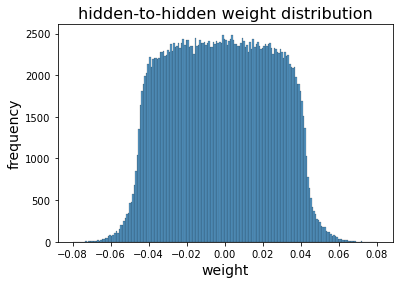

In [6]:
w = snn.plot_weights('hh', 'histogram')

In [ ]:
snn.save_to_numpy(modelname.split('.')[0])

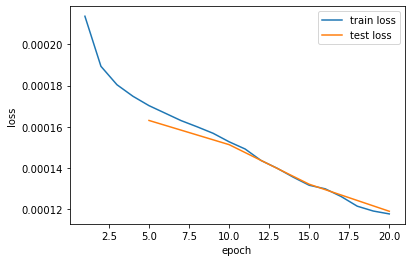

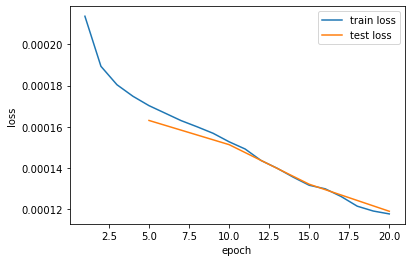

In [7]:
snn.plot_loss()

In [ ]:
loss_fig = snn.plot_loss()

In [ ]:
m = RSNN()

In [ ]:
m.load_model(modelname, 256, device)

In [ ]:
loss_fig = m.plot_loss()